SEMINAR: ASGER AND ALEXANDER 

Packages

In [98]:

from IPython.display import display
import numpy as np
import pandas as pd
import os
import datetime as dt

# Data file path
data_path = "/Users/alexanderstroustrup/Desktop/Dataseminar/"

# APIs
from fredapi import Fred
import yfinance as yf






# plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})


Now we start by getting the data from FRED 

In [99]:
with open('/Users/alexanderstroustrup/Desktop/fredkey.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

Now I get all the variables / tables I'm interested in

In [100]:
series = {
     "DGS10":"10YMY",
     "T10Y2Y":"10Y2Y",
     "DGS2":"2YMY",
}

Check their META data

In [101]:
for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

series id,DGS10,T10YIE,T10YIEM
title,Market Yield on U.S. Treasury Securities at 10...,10-Year Breakeven Inflation Rate,10-Year Breakeven Inflation Rate
frequency,Daily,Daily,Monthly
units,Percent,Percent,Percent


series id,T10Y2Y
title,10-Year Treasury Constant Maturity Minus 2-Yea...
frequency,Daily
units,Percent


series id,DGS2
title,Market Yield on U.S. Treasury Securities at 2-...
frequency,Daily
units,Percent


Now we download

In [102]:
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded DGS10           from FRED and saved it as 10YMY          
Downloaded T10Y2Y          from FRED and saved it as 10Y2Y          
Downloaded DGS2            from FRED and saved it as 2YMY           


In [103]:
df = pd.DataFrame(data)
#df = pd.concat(data.values(), axis=1).dropna() # does the same
df = df.dropna() # drop any rows with missing observations
df.index.name = "Date"
df.head()



,10YMY,10Y2Y,2YMY
Date,,,
1976-06-01,7.94,0.68,7.26
1976-06-02,7.94,0.71,7.23
1976-06-03,7.92,0.70,7.22
1976-06-04,7.89,0.77,7.12
1976-06-07,7.88,0.79,7.09


Now I save this dataset

In [104]:

df.to_csv(f"{data_path}fred.csv", index=True)


Now I get the data from yFinance. Here I get the S&P500, gold and Oil data.  

In [ ]:
df_ya = yf.download(
    tickers= ["^GSPC", "CL=F", "GC=F"],
    start="2001-01-01",
    end="2025-08-01",
    interval="1d",
    auto_adjust=True,   # adjusts for splits/dividends
    progress=False
)

#print(df_ya.head())
close_prices = df_ya['Close']
df_ya = df_ya.dropna() # drop any rows with missing observations
#print(close_prices.head())
close_prices.to_csv(f"{data_path}yfinance.csv", index=True)

# Calculate daily returns for the 'Close' prices
returns = close_prices.pct_change()

# Drop any rows with NaN values (e.g., the first row after calculating returns)
returns = returns.dropna()

# Display the first few rows of the returns
#print(returns.head())

# Save the returns to a CSV file
returns.to_csv(f"{data_path}yfinance_returns.csv", index=True)



Ticker           CL=F        GC=F        ^GSPC
Date                                          
2001-01-02  27.200001  268.399994  1283.270020
2001-01-03  27.950001  268.000000  1347.560059
2001-01-04  28.200001  267.299988  1333.339966
2001-01-05  28.000000  268.000000  1298.349976
2001-01-08  27.350000  268.000000  1295.859985
Ticker          CL=F      GC=F     ^GSPC
Date                                    
2001-01-03  0.027574 -0.001490  0.050099
2001-01-04  0.008945 -0.002612 -0.010552
2001-01-05 -0.007092  0.002619 -0.026242
2001-01-08 -0.023214  0.000000 -0.001918
2001-01-09  0.013528 -0.001866  0.003812


/var/folders/zd/f4t37l2x43j3y25px7y38fvw0000gn/T/ipykernel_74604/4113942113.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change()


Now we got the data for all variables. We now have to merge the data. 

In [107]:
# Load the two CSV files
df1 = pd.read_csv(f"{data_path}fred.csv")
df2 = pd.read_csv(f"{data_path}yfinance_returns.csv")

# Merge on the "Date" column
merged_df = pd.merge(df1, df2, on="Date", how="inner")  # 'inner' keeps only matching dates

# Optional: save the merged file
merged_df.to_csv(f"{data_path}merged_data.csv", index=False)

print(merged_df.head())

merged_df.to_csv(f"{data_path}merged_data.csv", index=True)



         Date  10YMY  10Y2Y  2YMY      CL=F      GC=F     ^GSPC
0  2001-01-03   5.14   0.22  4.92  0.027574 -0.001490  0.050099
1  2001-01-04   5.03   0.26  4.77  0.008945 -0.002612 -0.010552
2  2001-01-05   4.93   0.37  4.56 -0.007092  0.002619 -0.026242
3  2001-01-08   4.94   0.40  4.54 -0.023214  0.000000 -0.001918
4  2001-01-09   4.98   0.34  4.64  0.013528 -0.001866  0.003812


In [112]:

# ========================
# 1. Load your data
# ========================
# Assuming your CSV file looks like the example you gave:
df = pd.read_csv(f"{data_path}merged_data.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

# ========================
# 2. Define regimes
# ========================
# Level = 10Y yield, Slope = 10Y-2Y
level_median = df['10YMY'].median()
slope_median = df['10Y2Y'].median()

def regime(row):
    if row['10YMY'] < level_median and row['10Y2Y'] > slope_median:
        return 1  # Low level, steep slope
    elif row['10YMY'] < level_median and row['10Y2Y'] <= slope_median:
        return 2  # Low level, flat/inverted
    elif row['10YMY'] >= level_median and row['10Y2Y'] > slope_median:
        return 3  # High level, steep slope
    else:
        return 4  # High level, flat/inverted

df['Regime'] = df.apply(regime, axis=1)

print(df.head())

# ========================
# 4. Compute asset returns per regime
# ========================
df['Bonds'] = df['10YMY'] / 100 / 252


assets = ['GC=F','Bonds','CL=F','^GSPC']
avg_returns = df.groupby('Regime')[assets].mean()
print("Average returns per regime:")
print(avg_returns)



            Unnamed: 0  10YMY  10Y2Y  2YMY      CL=F      GC=F     ^GSPC  \
Date                                                                       
2001-01-03           0   5.14   0.22  4.92  0.027574 -0.001490  0.050099   
2001-01-04           1   5.03   0.26  4.77  0.008945 -0.002612 -0.010552   
2001-01-05           2   4.93   0.37  4.56 -0.007092  0.002619 -0.026242   
2001-01-08           3   4.94   0.40  4.54 -0.023214  0.000000 -0.001918   
2001-01-09           4   4.98   0.34  4.64  0.013528 -0.001866  0.003812   

            Regime  
Date                
2001-01-03       4  
2001-01-04       4  
2001-01-05       4  
2001-01-08       4  
2001-01-09       4  
Average returns per regime:
            GC=F     Bonds      CL=F     ^GSPC
Regime                                        
1       0.000031  0.000091 -0.000043  0.000453
2       0.000404  0.000079 -0.001563  0.000435
3       0.000514  0.000162  0.000657 -0.000046
4       0.000927  0.000174  0.000504  0.000391


Now I try to make a figure for the different regimes. Remember that the final regime edition has to be predicted from the in-sample only when backtesting. I might have to use the whole data set here when deriving the median for the two indicators. 

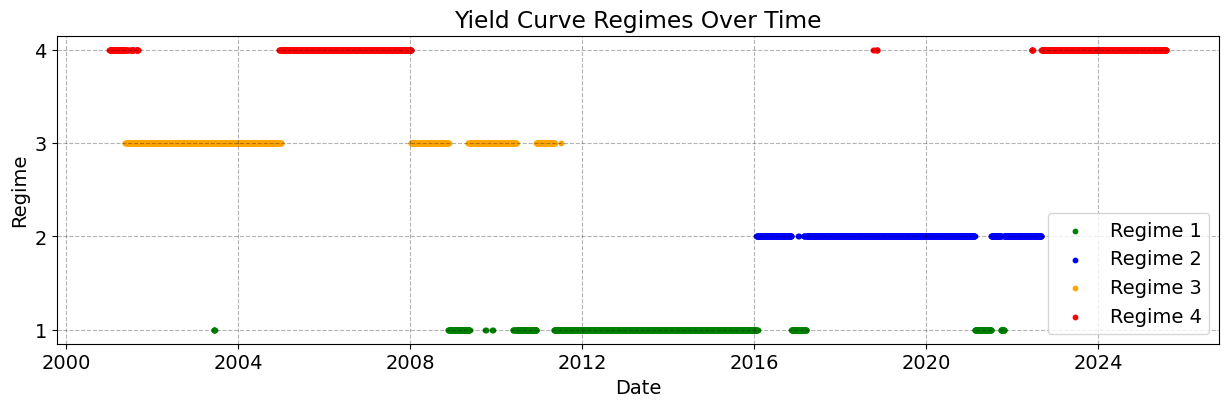

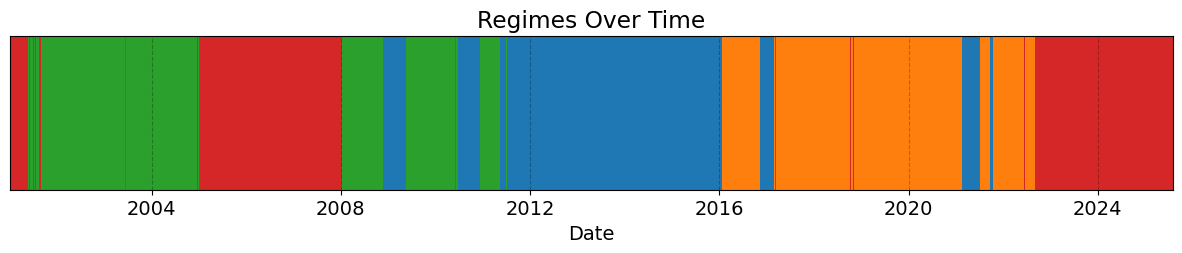

In [114]:
# Assuming df['Regime'] exists and df.index is datetime
regimes = df['Regime']

# Create a color map for 4 regimes
colors = {1: 'green', 2: 'blue', 3: 'orange', 4: 'red'}

# Plot
plt.figure(figsize=(15, 4))
for r in range(1, 5):
    regime_mask = regimes == r
    plt.scatter(df.index[regime_mask], [r]*regime_mask.sum(), 
                color=colors[r], label=f'Regime {r}', s=10)

plt.yticks([1, 2, 3, 4])
plt.xlabel('Date')
plt.ylabel('Regime')
plt.title('Yield Curve Regimes Over Time')
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

# Assume df.index is datetime and df['Regime'] contains 1-4
dates = df.index
regimes = df['Regime'].values

# Map regimes to colors
color_map = {1: '#1f77b4',  # blue
             2: '#ff7f0e',  # orange
             3: '#2ca02c',  # green
             4: '#d62728'}  # red
colors = [color_map[r] for r in regimes]

# Plot
fig, ax = plt.subplots(figsize=(15,2))

for i in range(len(dates)-1):
    ax.axvspan(dates[i], dates[i+1], color=colors[i], linewidth=0)

ax.set_yticks([])
ax.set_xlabel("Date")
ax.set_title("Regimes Over Time")
ax.set_xlim(dates[0], dates[-1])
plt.show()

Black litterman Optimization method

In [ ]:
# ========================
# 5. Black-Litterman setup (example for regime 1)
# ========================
w_mkt = np.array([0.25,0.25,0.25,0.25])  # equal weights for 4 assets
Sigma = df[assets].cov().values
tau = 0.05
pi = tau * Sigma @ w_mkt

# Example views: assume regime 1 favors Oil and Bonds
P = np.array([[0,1,1,0]])  # Bonds and Oil
Q = np.array([0.02])       # expected outperformance 2%
Omega = np.diag([0.0001])

# Posterior expected returns
M = np.linalg.inv(np.linalg.inv(tau*Sigma) + P.T @ np.linalg.inv(Omega) @ P)
posterior = M @ (np.linalg.inv(tau*Sigma) @ pi + P.T @ np.linalg.inv(Omega) @ Q)
print("Posterior expected returns (regime 1):", posterior)

# ========================
# 6. Mean-variance optimization
# ========================
def portfolio_vol(w, Sigma):
    return np.sqrt(w.T @ Sigma @ w)

target_return = posterior.mean()
n_assets = len(assets)

def objective(w):
    return portfolio_vol(w, Sigma)

constraints = (
    {'type':'eq', 'fun': lambda w: np.sum(w)-1},
    {'type':'eq', 'fun': lambda w: w @ posterior - target_return}
)
bounds = [(0,1) for _ in range(n_assets)]

res = minimize(objective, w_mkt, bounds=bounds, constraints=constraints)
w_opt = res.x

print("Optimal weights (regime 1):", dict(zip(assets, w_opt)))

# ========================
# 7. Optional: loop over all regimes
# ========================
optimal_weights = {}
for r in range(1,5):
    # example: views proportional to average returns in regime
    view_assets = avg_returns.loc[r].values
    P = np.eye(n_assets)  # simple view: each asset's return
    Q = view_assets       # expected return = average in that regime
    Omega = np.diag([0.0001]*n_assets)
    
    M = np.linalg.inv(np.linalg.inv(tau*Sigma) + P.T @ np.linalg.inv(Omega) @ P)
    posterior = M @ (np.linalg.inv(tau*Sigma) @ pi + P.T @ np.linalg.inv(Omega) @ Q)
    
    # Optimization
    def objective(w):
        return portfolio_vol(w, Sigma)
    constraints = (
        {'type':'eq', 'fun': lambda w: np.sum(w)-1},
        {'type':'eq', 'fun': lambda w: w @ posterior - posterior.mean()}
    )
    
    res = minimize(objective, w_mkt, bounds=bounds, constraints=constraints)
    optimal_weights[r] = dict(zip(assets, res.x))

print("Optimal weights per regime:")
for r, w in optimal_weights.items():
    print(f"Regime {r}:", w)